# Pasos previos para la Regresión logística

En este notebook descubriremos en qué se basa la regresión logística y haremos una primera toma de contacto con los conceptos más básicos que la rodean, que nos permitirán llegar a ella desde la regresión lineal.

### Tablas de frecuencias

En primer lugar, tenemos que hablar de las tablas de frecuencias, que nos permiten agrupar los valores de una columna en función de cierta variable.

En notebooks anteriores, hemos realizado unas cuantas veces un ``value_counts()`` de cualquier series, lo que nos devolvía un conteo de las veces que se daba cierto valor en una columna. Pues con las tablas de contingencia podremos obtener esto en función de otra variable, es decir, es como si hiciéramos un 'value_counts' haciendo un 'groupby'.

Veamos un ejemplo con un dataset de compras en función del género del cliente:

In [7]:
import pandas as pd

In [8]:
df = pd.read_csv("data/Gender Purchase.csv")
df.head()

,Gender,Purchase
0,Female,Yes
1,Female,Yes
2,Female,No
3,Male,No
4,Male,Yes


Como puedes ver, tenemos 2 variables: Género y si ha comprado o no. Con ``value_counts`` podríamos ver las veces que un cliente ha comprado o no, pero no podríamos tener en cuenta su género directamente. Con el método ``pd.crosstab()`` podemos hacerlo directamente:

In [6]:
df.shape

(511, 2)

In [85]:
tabla_contingencia = pd.crosstab(df["Gender"], df["Purchase"])
tabla_contingencia

Purchase,No,Yes
Gender,,
Female,106,159
Male,125,121


Muy bien, ya tenemos cuántos clientes mujer han comprado y cuántos no, así como de hombres. Si queremos completar la información de la tabla con los totales, podemos utilizar el argumento ``margins``:

In [82]:
pd.crosstab(df["Gender"], df["Purchase"], margins=True)

Purchase,No,Yes,All
Gender,,,
Female,106,159,265
Male,125,121,246
All,231,280,511


Pero lo que ahora nos interesa es obtener las probabilidades condicionadas al género, lo cuál podemos hacer del siguiente modo:

In [86]:
tabla_contingencia_prob = tabla_contingencia.copy()
totales = tabla_contingencia.sum(axis=1)
for i in range(len(totales)):
    tabla_contingencia_prob.iloc[i] = tabla_contingencia.iloc[i]/totales.iloc[i]
tabla_contingencia_prob

Purchase,No,Yes
Gender,,
Female,0.40000,0.60000
Male,0.50813,0.49187


Otra opción más directa es la siguiente (que es un poco distinta a lo que hemos visto, pero es muy compacta en este caso):

In [66]:
tabla_contingencia.div(tabla_contingencia.sum(axis=1), axis=0)

Purchase,No,Yes
Gender,,
Female,0.40000,0.60000
Male,0.50813,0.49187


Bueno, ¿y para qué hemos hecho todo esto? Todo tiene su explicación, necesitamos repasar qué es la probabilidad condicionada para entender la regresión logística.

### La probabilidad condicional

*En este apartado utilizaremos muchas fórmulas matemáticas, por lo que, en lugar de usar imágenes que puede que no se vean bien, nos ayudaremos de los siguientes módulos para poder representarlas:*

In [67]:
from IPython.display import display, Math, Latex

La probabilidad condicional, como explicamos en su día, nos permite conocer la probabilidad de un suceso, sabiendo si se dan o no ciertas condiciones en torno a él.

En este caso, nos pueden surgir preguntas como las siguientes (totalmente diferentes):

* ¿Cuál es la probabilidad de que un cliente compre un producto sabiendo que es un hombre?
* ¿Cuál es la probabilidad de que sabiendo que un cliente compra un producto sea mujer?

Como puedes comprobar, son cosas muy distintas, ya que estamos partiendo de supuestos diferentes.


A la primera pregunta podemos responder atendiendo a la siguiente ecuación:

In [75]:
display(Math(r'P(Purchase|Male) = \frac{Número\ total\ de\ compras\ hechas\ por\ hombres}{Número\ total\ de\ hombres\ del\ grupo} = \frac{Purchase\cap Male}{Male}'))

<IPython.core.display.Math object>

Analizando esta ecuación, llegamos a la conclusión de que el número de compras de un hombre lo podemos extraer de la tabla de contingencia que nos hemos creado:

In [91]:
tabla_contingencia.loc['Male', 'Yes']/tabla_contingencia.loc['Male'].sum()

0.491869918699187

En cuanto a la segunda pregunta, podemos proceder de manera similar a la anterior, llegando a la siguiente deducción:

In [87]:
display(Math(r'P(Female|Purchase) = \frac{Número\ total\ de\ compras\ hechas\ por\ mujeres}{Número\ total\ de\ compras} = \frac{Female\cap Purchase}{Purchase}'))

<IPython.core.display.Math object>

En este caso la cuestión es distinta, ya que la condición que se da por supuesta es la de compra y no la del género, es decir, el supuesto que damos por conocido "a priori" ha cambiado.

Ahora mismo, puede que no veamos la importancia de este hecho, pues tenemos la tabla con todos los datos y podemos calcular lo que estamos proponiendo directamente accediendo a los valores de la tabla de contingencia:

In [93]:
tabla_contingencia.loc['Female', 'Yes']/tabla_contingencia.loc[:, 'Yes'].sum()

0.5678571428571428

Sin embargo, si no tuviéramos todos los datos, sino que tuviéramos solo probabilidades en base a uno de los hechos, el otro no sería tan directo. Por ejemplo, si considerásemos que el hecho que conocemos (entre género y compra) es el género, las probabilidades de las que dispondríamos serían las siguientes:

In [94]:
display(Math(r'P(Purchase|Male)'))
print(tabla_contingencia.loc['Male', 'Yes']/tabla_contingencia.loc['Male'].sum())
display(Math(r'P(NO\ Purchase|Male)'))
print(tabla_contingencia.loc['Male', 'No']/tabla_contingencia.loc['Male'].sum())
display(Math(r'P(Purchase|Female)'))
print(tabla_contingencia.loc['Female', 'Yes']/tabla_contingencia.loc['Female'].sum())
display(Math(r'P(NO\ Purchase|Female)'))
print(tabla_contingencia.loc['Female', 'No']/tabla_contingencia.loc['Female'].sum())

<IPython.core.display.Math object>

0.491869918699187


<IPython.core.display.Math object>

0.508130081300813


<IPython.core.display.Math object>

0.6


<IPython.core.display.Math object>

0.4


Como puedes ver, coinciden con la tabla que habíamos sacado. No es casualidad, pues lo que hemos sacado anteriormente es la tabla de probabilidades en base al género. Y son estas las probabilidades condicionadas que necesitamos para hacer nuestro modelo predictivo.

### Comparando probabilidades: Ratios

El ratio de probabilidades de un suceso es el ratio de éxito de un suceso estudiado frente a los fracasos del mismo, para cada grupo analizado.

Por ejemplo, basándonos en las probabilidades que hemos sacado anteriormente, donde tenemos las probabilidades en base al género, podemos definir los ratios como:

In [133]:
display(Math(r'P_m = \ probabilidad\ de\ hacer\ compra\ sabiendo\ que\ es \ un \ hombre'))

display(Math(r'P_f = \ probabilidad\ de\ hacer\ compra\ sabiendo\ que\ es \ una\ mujer'))

display(Math(r'N_{m,p} = \ número\ de\ hombres\ que\ compran'))

display(Math(r'N_{f,p} = \ número\ de\ mujeres\ que\ compran'))

display(Math(r'N_{m,\bar p} = \ número\ de\ hombres\ que\ no\ compran'))

display(Math(r'N_{f,\bar p} = \ número\ de\ mujeres\ que\ no\ compran'))

display(Math(r'ratio\in[0,+\infty]'))

display(Math(r'ratio_{p,m} = \frac{P_m}{1-P_m} = \frac{N_{m,p}}{N_{m,\bar p}}'))

display(Math(r'ratio_{p,f} = \frac{P_F}{1-P_F} = \frac{N_{f,p}}{N_{f,\bar p}}'))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [134]:
# Probabilidad compra sabiendo hombre:
pm = tabla_contingencia.loc['Male', 'Yes']/tabla_contingencia.loc['Male'].sum()

# Probabilidad compra sabiendo mujer:
pf = tabla_contingencia.loc['Female', 'Yes']/tabla_contingencia.loc['Female'].sum()

# Ratio hombres:
ratio_m = pm/(1-pm)
## Equivalente a :
# tabla_contingencia.loc['Male', 'Yes']/tabla_contingencia.loc['Male', 'No']

# Ratio mujeres:
ratio_f = pf/(1-pf)
## Equivalente a :
# tabla_contingencia.loc['Female', 'Yes']/tabla_contingencia.loc['Female', 'No']

In [135]:
ratio_m

0.9680000000000002

In [136]:
ratio_f

1.4999999999999998

En este caso, comparando los ratios, vemos que es superior para las mujeres que para los hombres, por lo que podemos deducir que las mujeres son más propensas a comprar que los hombres, tienen más probabilidades de realizar la compra que los hombres, tienen más éxito.

Bien, pues podemos extraer ciertos ``bullets`` en función del valor del raito que no tenemos que perder de vista, ya que serán fundamentales para entender la regresión logística:

* <span style="color: rgb(0, 222, 0);"><b>ratio > 1</b></span> 🡆 $P(éxito) > P(fracaso)$, donde si $↑ ratio → ↑ P(éxito)$
* <span style="color: rgb(0, 0, 222);"><b>ratio = 1</b></span> 🡆 $P(éxito) = P(fracaso)$
* <span style="color: rgb(222, 0, 0);"><b>ratio < 1</b></span> 🡆 $P(éxito) < P(fracaso)$, donde si $↓ ratio → ↓ P(éxito)$
    
    
También podríamos hacer el cociente de probabilidades, que será haciendo la división de un ratio entre el otro, el cual, evidentemente, será mayor que 1 si el que ponemos en el numerador es mayor que el que ponemos en el denominador, lo que significará que el experimento que domina será el primero.

In [137]:
# Ratio global para hombres:
ratio_global_m = ratio_m / ratio_f
ratio_global_m

0.6453333333333335

In [138]:
# Ratio global para hombres:
ratio_global_f = ratio_f / ratio_m
ratio_global_f

1.5495867768595035

In [139]:
1/ratio_global

1.5495867768595037

### Llegando a nuestro destino: relación entre la regresión lineal y la regresión logística

Si recordáis lo que hemos visto en los notebooks anteriores, la expresión de la regresión lineal viene dada por la siguiente fórmula:

In [142]:
display(Math(r'y = \alpha + \beta \cdot x'))
display(Math(r'(x,y)\in[-\infty, +\infty]^2'))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Donde ``x`` e ``y`` eran variables continuas definidas en $(-\inf, +\inf)$

Sin embargo, cuando nos ponemos a pensar en la regresión logística, las cosas cambian. En primer lugar, como lo que busco ya no es un número sino una clase (en este ejemplo, pensemos en un decisor binario), la salida de mi sistema tiene que ser $0$ o $1$, no me valen medias tintas.

Por lo tanto, podríamos definir y como:

$Y \in \{0, 1\}$

Pero, ¿cómo puedo obtener yo eso? Bueno, para esto podríamos definir un parámetro ``P`` definido como un valor comprendido entre 0 y 1:

$P \in [0, 1]$

Este parámetro ``P`` hará referencia a una probabilidad, que como sabemos varía en los márgenes que acabamos de definir. El cálculo de este parámetro será el punto base de la regresión logística. Pero, ¿cómo lo calculamos? Pues muy sencillo, aquí es donde entra la regresión lineal (muahahaha).

Podemos definir la probabilidad como sigue:

$P = \alpha + \beta * X$

Además, ``P`` no será una probabilidad cualquiera, no. Ya que nos la hemos creado que sea más guay que el resto. ``P`` va a ser una probabilidad que dependa de un parámetro ``X``. Es más, vamos a definir a ``P`` como la probabilidad condicionada de éxito o fracaso a la presencia de la variable ``X``. ¿Por qué hacemos esto? Bueno, como ya estamos limitando mucho a ``P``, vamos a dejar al menos alguien pueda ser libre, así que ``X`` estará definido en:

$X \in (-\infty, +\infty)$


Vamos a dar un paso más, en vez de ``P``, vamos a hacer que sea el cociente de probabilidades de ``P`` el que esté definido de forma lineal, es decir:

$\frac{P}{1-P} = \alpha + \beta\cdot X\in [0,+\infty)$

Por lo que ahora, ya hemos reducido ese $(-\infty,+\infty)$ de ``X`` a la mitad positiva. ¡Casi lo tenemos!

Bueno, pues si has podido llegar hasta aquí, ahora te v a explotar la cabeza, ¿qué pasaría si aplicamos la función logaritmo sobre algo que va entre 0 e infinito?

Pues te lo creas o no, las características principales de los logaritmos hacen que se cumpla lo siguiente:

$\begin{cases}\frac{P}{1-P}\in[0,1]\Rightarrow ln(\frac{P}{1-P})\in(-\infty,0]\\ \frac{P}{1-P}\in[1,+\infty)\Rightarrow ln(\frac{P}{1-P})\in[0, \infty)\end{cases}$

Lo que equivale a que:

$\begin{cases}P\in[0,\frac{1}{2}]\Rightarrow ln(\frac{P}{1-P})\in(-\infty,0]\\ P\in[\frac{1}{2},1]\Rightarrow ln(\frac{P}{1-P})\in[0, \infty)\end{cases}$


Ahora sí parece que van saliendo las cosas, ya que hemos conseguido igualar los rangos de ambos lados de la igualdad.

Finalmente, nos quedaría poner las cosas bonitas:

$ ln(\frac{P}{1-P}) = \alpha + \beta\cdot X$

$\frac{P}{1-P} = e^{\alpha + \beta\cdot X}$

$P = \frac{e^{\alpha+\beta\cdot X}}{1+e^{\alpha+\beta\cdot X}}$

Llegando a la típica ecuación que define una regresión logística:

<center>$P = \frac{1}{1+e^{-(\alpha+\beta\cdot X)}}$</center>

donde podemos observar que:


* <span style="color: rgb(0, 222, 0);"><b>$a + bX > 0.5$ </b></span> 🡆 $P → 1$
* <span style="color: rgb(0, 0, 222);"><b>$a + bX = 0.5$</b></span> 🡆 $P = 0,5$
* <span style="color: rgb(222, 0, 0);"><b>$a + bX < 0.5$ </b></span> 🡆 $P → 0$

¿Te recuerda a algo?





Vamos a hacer una gráfica para a=0 y b=1 para ver cómo es esta función:

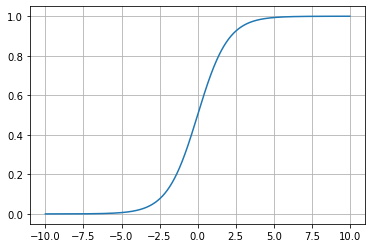

In [153]:
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(-10, 10, 1000)
a = 0
b = 1
f = a + b*x
P = 1/(1+np.exp(-f))

plt.plot(x, P)
plt.grid()

### Extra: ¿Y si quiero hacer una regresión logística múltiple?

Finalmente, si quisiéramos saber cómo podríamos desarrollarlo para llegar a la regresión logística múltiple, no sería demasiado complicado (para nosotros, que no lo vamos a demostrar). Simplemente, aplicando sumatorios podríamos llegar a lo siguiente:

<center>$P = \frac{1}{1+e^{-(\alpha+\sum_{i=1}^n\beta_i\cdot x_i)}}$</center>